## **Implementation of Convolutional Neural Network (CNN)**

In [1]:
import os
import random
import zipfile
import platform
import psutil
import glob
import time
import cv2
import gc
import PIL

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import torchvision
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv
from sklearn.manifold import TSNE

from tqdm import tqdm
from tqdm.notebook import tqdm
import itertools
from PIL import Image
from PIL import ImageOps
from tabulate import tabulate
from collections import OrderedDict

## **Load and Prepare Dataset**

In [2]:
# Define the data directory (adjust to your dataset structure)
data_dir = "/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image"

# Verify file structure
for dirname, _, filenames in os.walk("/kaggle/input/gastric-cancer-data"):
    for filename in filenames[:]:  # limit output to avoid spam
        print(os.path.join(dirname, filename))

# Gather file paths and labels
file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):  # Ensure it's a directory
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

# Create DataFrame
df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle the dataset

# Display sample
df.head()

/kaggle/input/gastric-cancer-data/HMU-GC-Clinical.csv
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_2940.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_3357.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_3294.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_3050.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_3119.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_3133.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_2937.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_3743.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_1592.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_332.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_1810.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_2896.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K

file_path label
0  /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   LYM
1  /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   LYM
2  /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   MUC
3  /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   ADI
4  /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   MUC

## **Visualize Class Distribution**


Class: LYM, Count: 3887
Class: MUC, Count: 3887
Class: ADI, Count: 3887
Class: DEB, Count: 3887
Class: TUM, Count: 3887
Class: MUS, Count: 3887
Class: NOR, Count: 3887
Class: STR, Count: 3887


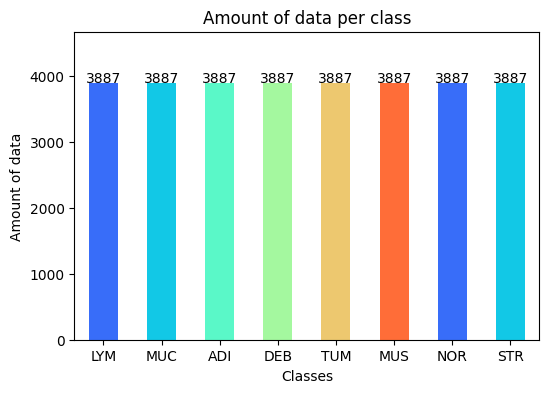

In [3]:
class_counts_train = df['label'].value_counts()
for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(6, 4))
ax = class_counts_train.plot(kind='bar', color=sns.color_palette('rainbow'))
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
plt.title('Amount of data per class')

for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

## **Random Image Visualization**

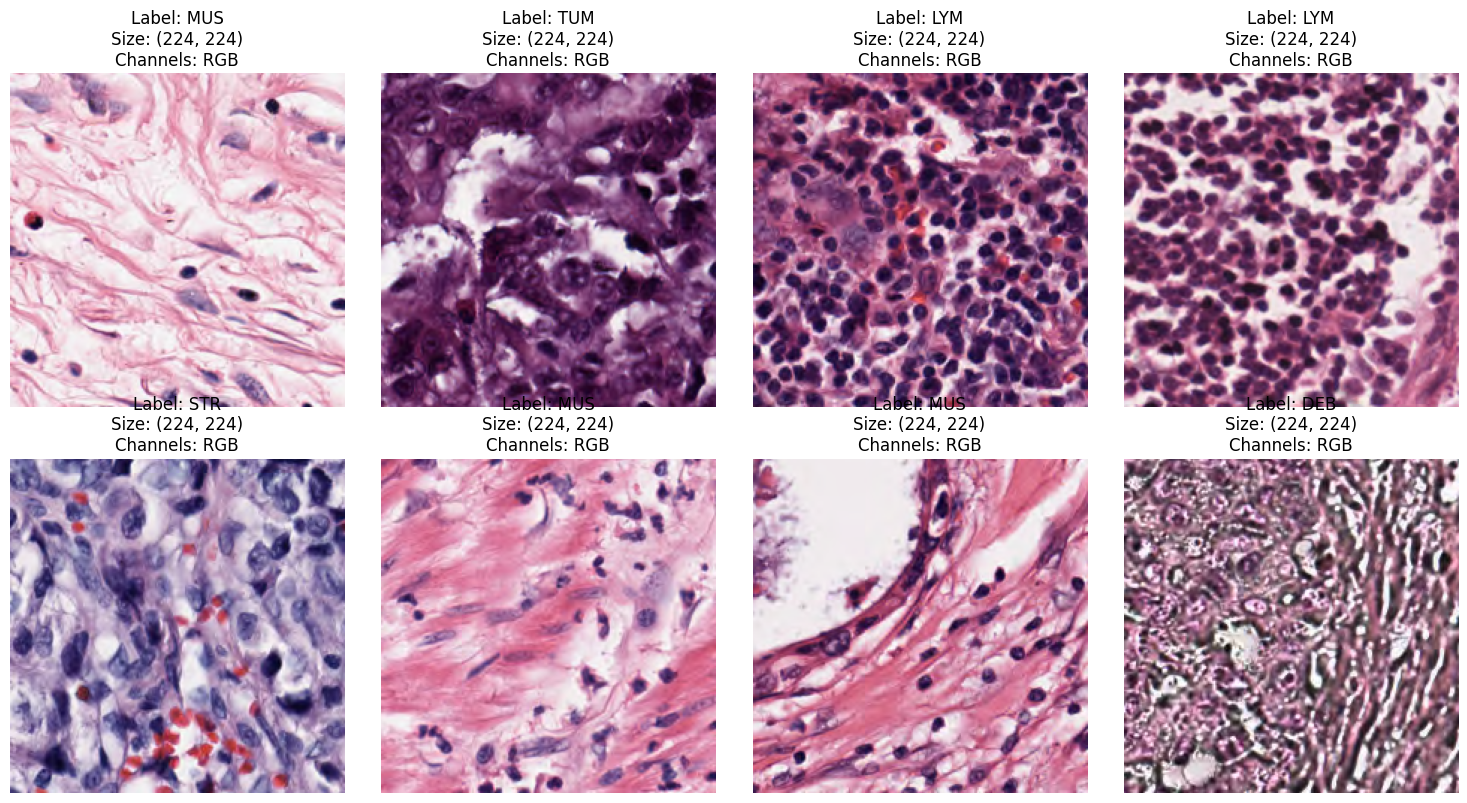

In [4]:
num_images_to_show = 8
rows = 2
cols = 4
plt.figure(figsize=(15, 8))

for i in range(num_images_to_show):
    random_index = random.randint(1, len(df) - 1)
    random_row = df.iloc[random_index]
    file_path = random_row['file_path']
    label = random_row['label']
    image = Image.open(file_path)
    size = image.size
    channels = 'Grayscale' if image.mode == 'L' else 'RGB'

    plt.subplot(rows, cols, i + 1)  # Create subplots for each image
    plt.title(f"Label: {label}\nSize: {size}\nChannels: {channels}")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Split the Dataset into Training, Validation and Test set**

In [5]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
test_dataframe, valid_dataframe = train_test_split(temp_dataframe, test_size=0.5, stratify=temp_dataframe['label'], random_state=42)

In [6]:
print("Training Data (80%) :", len(train_dataframe))
print("Validation Data : ", len(valid_dataframe))
print("Test Data : ", len(test_dataframe))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data (80%) : 24876
Validation Data :  3110
Test Data :  3110
-------------------------------------------
Total amounts of data in the dataset:  31096


**Device Configuration**

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### **Dataset Class, Dataloader and Transform**

In [8]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        # Always convert labels to integers, regardless of is_lb
        self.is_lb = True
        self.label_map = {'ADI': 0, 'DEB': 1, 'LYM': 2, 'MUC': 3, 'MUS': 4, 'NOR': 5, 'STR': 6, 'TUM': 7}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)
        image = image.convert('RGB')
        # Convert label to integer using label_map
        label = self.label_map[self.dataframe.iloc[index]['label']]

        # Check if label is within the valid range and convert to LongTensor
        if not 0 <= label < 8:
            print(f"Warning: Invalid label value: {label} at index {index}, Image Path: {img_path}")
            label = 0  # Or handle the invalid label in another way

        # Ensure the image is of the correct data type
        image = self.normalize(image).type(torch.FloatTensor)

        return image, torch.tensor(label, dtype=torch.long) # Convert label to LongTensor

In [9]:
batch = 32

def data_transfrom():
    normalize = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    train_dataset = ImageDataset (
        train_dataframe,
        normalize,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_dataframe,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

## **Design and Implementation of CNN model**

In [10]:
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512) # The input size to this layer should match the output size of the previous layers.
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 8)  # 8 output classes to match the number of classes in your dataset.

        # Dropout layer (to prevent overfitting)
        self.dropout = nn.Dropout(0.5) # contorl 50% on or off

    def forward(self, x):
        # First convolutional block
        x = self.pool(F.relu(self.conv1(x)))

        # Second convolutional block
        x = self.pool(F.relu(self.conv2(x)))

        # Third convolutional block
        x = self.pool(F.relu(self.conv3(x)))

        # Print the shape of x before flattening for debugging
        print("Shape of x before flattening:", x.shape)

        # Flatten the output for the fully connected layers
        x = x.view(-1, 128 * 28 * 28) # Ensure this matches the output size of the convolutional layers.

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [11]:
model = CNN_model()
model = model.to(device)
print(model.parameters)
criterion = nn.CrossEntropyLoss() # Find Wrong
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)

<bound method Module.parameters of CNN_model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=8, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)>


In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`

    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): # itertools is now accessible
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Data transforms for training and validation

In [13]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
}

In [14]:
data_dir = "/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image"

image_datasets = {
    x: datasets.ImageFolder(data_dir, transform=data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

### **List of pretrained models to experiment with**

In [15]:
pretrained_models = {
    #'resnet152': models.resnet18(pretrained=True),
    #'resnet50': models.resnet50(pretrained=True),
    #'densenet201': models.densenet201(pretrained=True)
    #'efficientnet_v2_l': models.efficientnet_v2_l(pretrained=True)
    'efficientnet_b3': models.efficientnet_b3(pretrained=True),
}

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 185MB/s]


In [16]:
num_classes = len(class_names)
print(f"Number of classes:{num_classes}")
num_epochs = 45  # Adjust as needed

Number of classes:8


**Evaluate Model and Metrics Calculation**

In [17]:
def train_and_evaluate_model(model, model_name):
    # Modify final layer according to the architecture
    if model_name.startswith('DenseNet'):
        num_ftrs = model.classifier.in_features  # Use 'classifier' instead of 'fc'
        model.classifier = nn.Linear(num_ftrs, num_classes)  # Replace 'fc' with 'classifier'
    elif 'efficientnet' in model_name:
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    print(f"\nTraining model: {model_name}")

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    learning_rates_history = []
    training_loss_history = []
    validation_loss_history = []
    
    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Clear CUDA cache after each epoch or phase
            torch.cuda.empty_cache()
            gc.collect()

    # After training, evaluate on the validation set:
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []  # to store probabilities for ROC curve

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Classification report and confusion matrix
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds) # Assign the confusion matrix to cm
    #print(cm)

    plot_confusion_matrix(cm, classes=class_names, title=f'Confusion Matrix for {model_name}')
    # ROC curve for each class (One-vs-Rest)
    fpr = {}
    tpr = {}
    roc_auc = {}
    # Binarize the output labels for multi-class ROC computation
    labels_binarized = label_binarize(all_labels, classes=range(num_classes))

    plt.figure()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i],
                 label=f'ROC curve for {class_names[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    epochs = range(1, len(learning_rates_history) + 1)
    plt.plot(epochs, learning_rates_history, label="Learning Rate")
    plt.plot(epochs, training_loss_history, label="Training Loss")
    plt.plot(epochs, validation_loss_history, label="Validation Loss")

    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title(f"Learning Rate, Training Loss & Validation Loss ({model_name})")
    plt.legend()
    plt.show()

    # Loss Plot
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Accuracy Plot
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    
    # Extract features using the penultimate layer of the model
    model.eval()
    features = []
    labels_list = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            # Extract up to the avgpool layer
            x = model.features(inputs)
            x = model.avgpool(x)  # Use avgpool, not global_avg_pool
            x = torch.flatten(x, 1)
            features.append(x.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    features = np.concatenate(features, axis=0)
    labels_list = np.concatenate(labels_list, axis=0)

    # t-SNE for 2D projection
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_results = tsne.fit_transform(features)

    plt.figure(figsize=(8, 6))
    for class_idx in range(num_classes):
        idxs = labels_list == class_idx
        plt.scatter(tsne_results[idxs, 0], tsne_results[idxs, 1], label=class_names[class_idx], alpha=0.6)

    plt.legend()
    plt.title("t-SNE Visualization of Validation Features")
    plt.xlabel("TSNE 1")
    plt.ylabel("TSNE 2")
    plt.grid(True)
    plt.show()

    # Standardize the features before PCA or GMM
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # PCA Visualization (2D)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features_scaled)

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        idxs = labels_list == i
        plt.scatter(pca_result[idxs, 0], pca_result[idxs, 1], label=class_names[i], alpha=0.6)

    plt.legend()
    plt.title('PCA Projection of Validation Features (Standardized)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)
    plt.show()

    # GMM Clustering Visualization
    gmm = GaussianMixture(n_components=num_classes, random_state=42)
    gmm_labels = gmm.fit_predict(features_scaled)

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        idxs = gmm_labels == i
        plt.scatter(pca_result[idxs, 0], pca_result[idxs, 1], label=f'GMM Cluster {i}', alpha=0.6)

    plt.legend()
    plt.title('GMM Clustering in PCA Space (Standardized)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)
    plt.show()

    # Alvo Method (Mahalanobis Distance)
    mean_vector = np.mean(pca_result, axis=0)
    cov_matrix = np.cov(pca_result.T)
    inv_cov_matrix = inv(cov_matrix)

    distances = [mahalanobis(x, mean_vector, inv_cov_matrix) for x in pca_result]

    plt.figure(figsize=(8, 6))
    plt.hist(distances, bins=50, color='purple', alpha=0.7)
    plt.title("Alvo-style Outlier Score (Mahalanobis Distance in PCA Space)")
    plt.xlabel("Distance from Cluster Center")
    plt.ylabel("Number of Samples")
    plt.grid(True)
    plt.show()    

### **Loop through each pretrained model, train and evaluate**


Training model: efficientnet_b3
Epoch 1/45
Train Loss: 1.3259 Acc: 0.5071
Val Loss: 0.9041 Acc: 0.6637
Epoch 2/45
Train Loss: 1.1223 Acc: 0.5855
Val Loss: 0.8307 Acc: 0.6899
Epoch 3/45
Train Loss: 1.0544 Acc: 0.6065
Val Loss: 0.7809 Acc: 0.7056
Epoch 4/45
Train Loss: 1.0121 Acc: 0.6259
Val Loss: 0.6979 Acc: 0.7349
Epoch 5/45
Train Loss: 0.9840 Acc: 0.6360
Val Loss: 0.6895 Acc: 0.7440
Epoch 6/45
Train Loss: 0.9525 Acc: 0.6437
Val Loss: 0.6654 Acc: 0.7528
Epoch 7/45
Train Loss: 0.9332 Acc: 0.6528
Val Loss: 0.6321 Acc: 0.7594
Epoch 8/45
Train Loss: 0.9250 Acc: 0.6564
Val Loss: 0.6277 Acc: 0.7700
Epoch 9/45
Train Loss: 0.9100 Acc: 0.6629
Val Loss: 0.6082 Acc: 0.7724
Epoch 10/45
Train Loss: 0.9015 Acc: 0.6621
Val Loss: 0.5981 Acc: 0.7761
Epoch 11/45
Train Loss: 0.8788 Acc: 0.6723
Val Loss: 0.5697 Acc: 0.7872
Epoch 12/45
Train Loss: 0.8602 Acc: 0.6777
Val Loss: 0.5537 Acc: 0.7931
Epoch 13/45
Train Loss: 0.8509 Acc: 0.6855
Val Loss: 0.5366 Acc: 0.8002
Epoch 14/45
Train Loss: 0.8472 Acc: 0.68

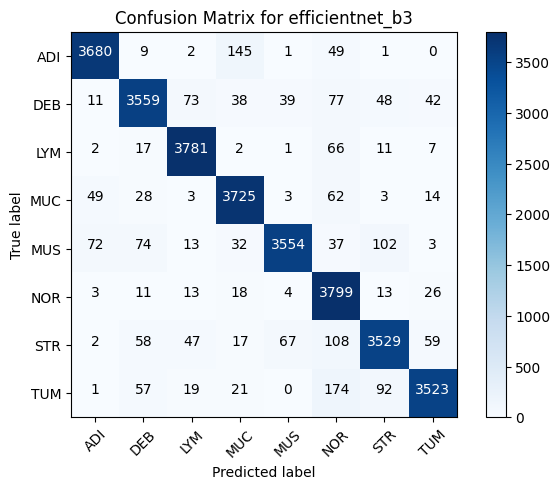

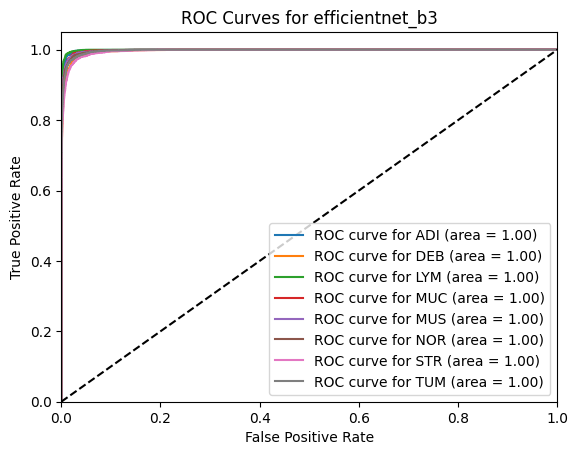

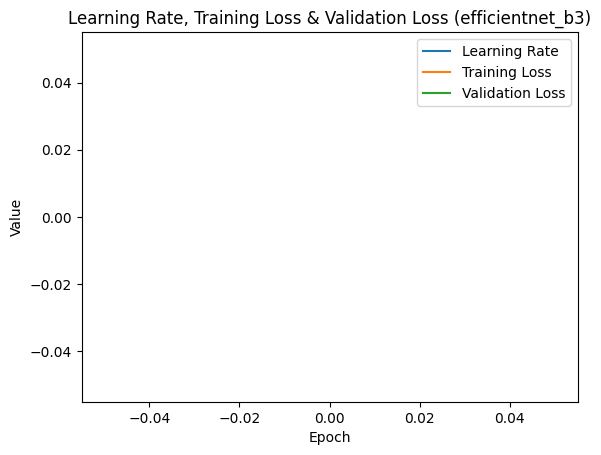

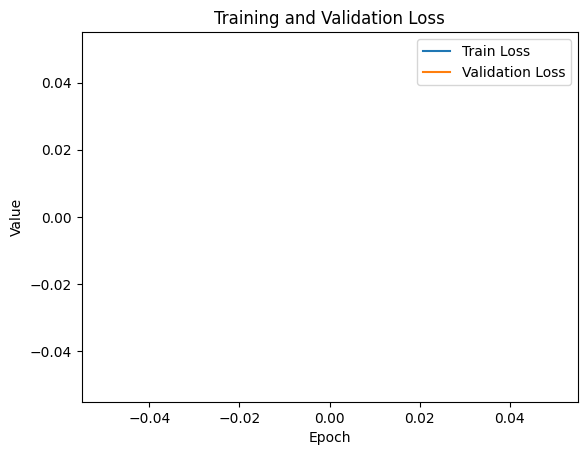

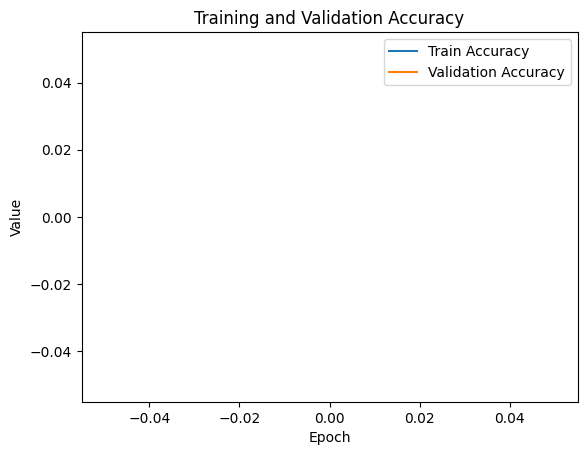

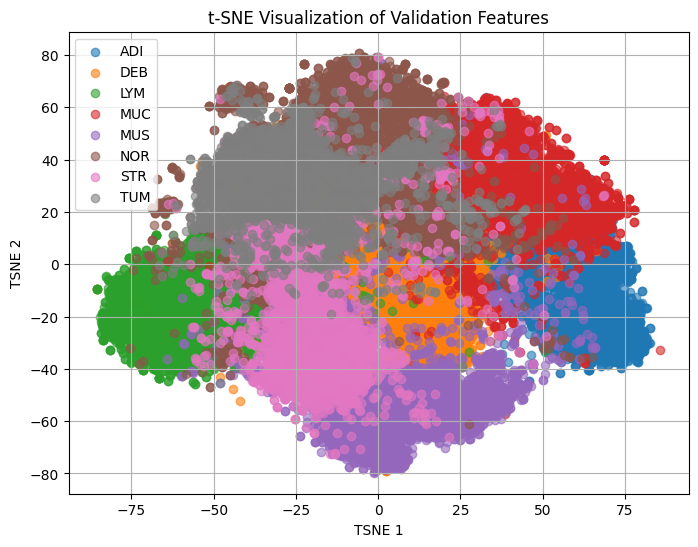

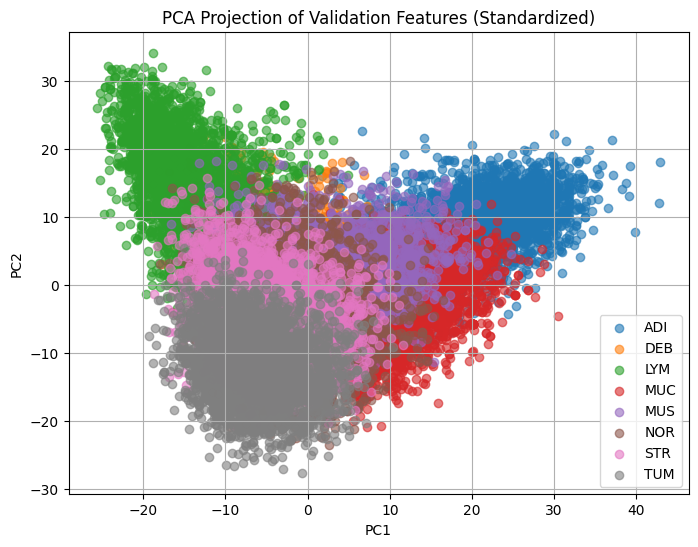

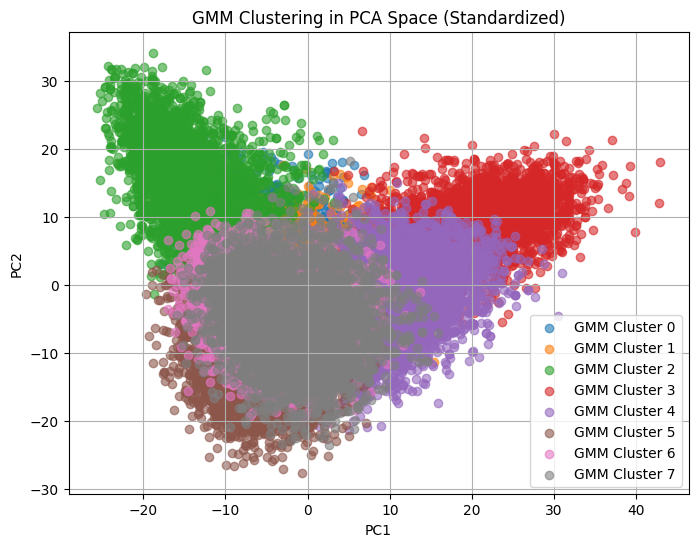

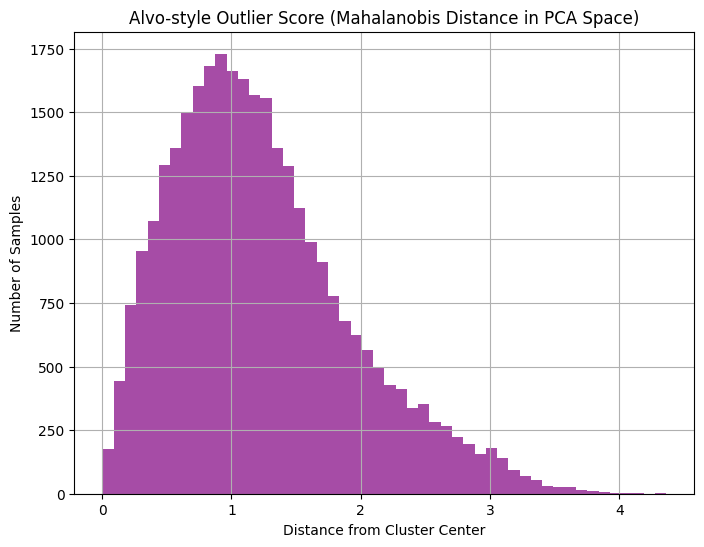

In [18]:
for name, model in pretrained_models.items():
    train_and_evaluate_model(model, name)